In [1]:
%cd ..

/home/feodor/Jupyter/depth-poset


/home/feodor/Jupyter/jupyter-env/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import itertools
import inspect
import time

import numpy as np
import pandas as pd
import gudhi as gh
import networkx as nx

from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

from src import depth
from src.depth import DepthPoset
from src.drow import plot_filtred_complex2d, plot_simplex, enumerate_points

from tqdm import tqdm

# The Simplicial Complex

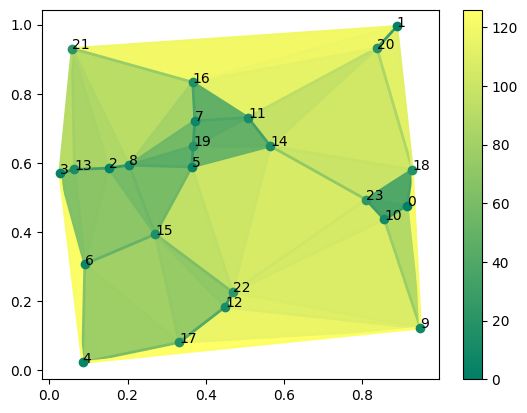

In [3]:
n, dim = 24, 2
points = np.random.random([n, dim])

stree = gh.AlphaComplex(points).create_simplex_tree()
simplices = [simplex for simplex, value in stree.get_filtration()]
filtration_values = np.asarray([value for simplex, value in stree.get_filtration()])
new_filtration_values = np.argsort(filtration_values)
for simplex, value in zip(simplices, new_filtration_values):
    stree.assign_filtration(simplex, value)

sm = plot_filtred_complex2d(stree, points, cmap='summer')
plt.colorbar(sm, ax=plt.gca())
enumerate_points(points)

# Define and iterate the Transpositions

In [4]:
def order_is_possible(order):
    # returns False if there are bigger simplices before the smallest
    for i0 in range(len(order)):
        for i1 in range(i0 + 1, len(order)):
            s0 = np.sort(order[i0])
            s1 = np.sort(order[i1])
            intersection = np.intersect1d(s0, s1)
            if list(s1) == list(intersection):
                return False
    return True

In [5]:
def iterate_possible_transpositions_indices(order, neighbours=True):
    # 
    if neighbours:
        generator = np.transpose([np.arange(len(order) - 1), np.arange(len(order) - 1) + 1])
    else:
        generator = itertools.combinations(range(len(order)), 2)
    for i0, i1 in generator:
        new_order = order.copy()
        new_order[i0], new_order[i1] = new_order[i1], new_order[i0]
        if order_is_possible(new_order):
            yield i0, i1

In [6]:
def get_transposition_type(stree: gh.SimplexTree, s0, s1):
    """
    Returns the type of the transpositon (birth-birth, death-deat, birth-death, another) of 2 simplices: s0 and s1
    """
    s0, s1 = tuple(np.sort(s0)), tuple(np.sort(s1))
    try:
        pairs = stree.persistence_pairs()
    except AssertionError:
        stree.compute_persistence()
        pairs = stree.persistence_pairs() 
    births = [tuple(np.sort(pair[0])) for pair in pairs]
    deaths = [tuple(np.sort(pair[1])) for pair in pairs]
    if s0 in births and s1 in births:
        return 'birth-birth'
    if s0 in deaths and s1 in deaths:
        return 'death-death'
    if s0 in births and s1 in deaths:
        return 'birth-death'
    if s0 in deaths and s1 in births:
        return 'birth-death'

In [7]:
def get_transposition(stree: gh.SimplexTree, i0, i1, order=None):
    # 
    if order is None:
        order = [simplex for simplex, value in stree.get_filtration()]
    return {'index 0': i0, 
            'index 1': i1, 
            'value 0': stree.filtration(order[i0]), 
            'value 1': stree.filtration(order[i1]), 
            'simplex 0': order[i0], 
            'simplex 1': order[i1], 
            'dim 0': len(order[i0]) - 1, 
            'dim 1': len(order[i1]) - 1, 
            'type': get_transposition_type(stree, order[i0], order[i1])
           }

In [8]:
def iterate_possible_transpositions(stree: gh.SimplexTree, neighbours=True, transposition_type=None):
    # 
    order = [simplex for simplex, value in stree.get_filtration()]
    for i0, i1 in iterate_possible_transpositions_indices(order, neighbours=neighbours):
        transposition = get_transposition(stree, i0, i1, order=order)
        if (transposition_type is None) or (transposition_type == transposition['type']):
            yield transposition

In [9]:
timer = time.perf_counter()
df_transpositions = pd.DataFrame(iterate_possible_transpositions(stree))
timer = time.perf_counter() - timer

print(f'Transpositions are found in {timer:.4f} seconds.\n')
print(f'Transposition types distribution:\n{
        '\n'.join(str(df_transpositions['type'].value_counts()).split('\n')[1:-1])
        }\n')

print(f'df_transpositions.shape = {df_transpositions.shape}')
df_transpositions.head()

Transpositions are found in 18.9663 seconds.

Transposition types distribution:
birth-death    37
birth-birth    28
death-death    27

df_transpositions.shape = (92, 9)


,index 0,index 1,value 0,value 1,simplex 0,simplex 1,dim 0,dim 1,type
0,0,1,0.0,1.0,[0],[1],0,0,birth-birth
1,1,2,1.0,2.0,[1],[2],0,0,birth-birth
2,2,3,2.0,3.0,[2],[3],0,0,birth-birth
3,3,4,3.0,4.0,[3],[4],0,0,birth-birth
4,4,5,4.0,5.0,[4],[5],0,0,birth-birth


## Plot the Transposition

In [10]:
def plot_transposition(transposition, stree0, stree1, dp0, dp1, fig=None, axs=None, figsize=(9, 8), cmap='summer'):
    # returns fig, axs
    s0 = transposition['simplex 0']
    s1 = transposition['simplex 1']

    if fig is None or axs is None:
        fig, axs = plt.subplots(2, 2, figsize=figsize)
    
    fig.suptitle(f'The {transposition['type'].replace('b', 'B').replace('d', 'D')} Transposition of Simplices {s0} and {s1}')
    axs[0, 0].set_title('Complex before the Transposition')
    axs[0, 1].set_title('Complex after the Transposition')
    axs[1, 0].set_title('Depth Poset before the Transposition')
    axs[1, 1].set_title('Depth Poset after the Transposition')
    
    
    for i, streei in enumerate([stree0, stree1]):
        sm = plot_filtred_complex2d(streei, points, ax=axs[0, i], cmap=cmap, linewidth=4)
        plt.colorbar(sm, ax=axs[0, i])
    
        plot_simplex(s0, points, ax=axs[0, i], color='red', marker='x', linestyle=':', hatch='+', 
                 label=f'f({s0}) = {streei.filtration(s0)}', zorder=4)
        plot_simplex(s1, points, ax=axs[0, i], color='blue', marker='x', linestyle=':', hatch='+', 
                 label=f'f({s1}) = {streei.filtration(s1)}', zorder=4)
        enumerate_points(points, ax=axs[0, i])
        axs[0, i].legend()
    
    for i, dpi in enumerate([dp0, dp1]):
        node_color = ['gold' if tuple(s0) in node.source or tuple(s1) in node.source else 'teal' for node in dpi.nodes]
        nx.draw_networkx(dpi.get_transitive_reduction(), pos=dpi.persistant_layout(), ax=axs[1, i], 
                         node_color=node_color, node_size=36, 
                         labels=dpi.get_labels(), 
                         with_labels=False, hide_ticks=False)
        axs[1, i].fill_between([0, max(dpi.get_filtration_values())], 
                               [0, max(dpi.get_filtration_values())], [0, 0], color='lightgrey')
        axs[1, i].set_xlim(*(max(dpi.get_filtration_values())*np.array([-0.05, 1.05])))
        axs[1, i].set_ylim(*(max(dpi.get_filtration_values())*np.array([-0.05, 1.05])))

    return fig, axs

In [11]:
def get_strees(transposition, stree: gh.SimplexTree):
    # returns 2 SimplexTrees, before and after the transposition
    s0, s1 = transposition['simplex 0'], transposition['simplex 1']
    v0, v1 = transposition['value 0'], transposition['value 1']
    stree0 = stree.copy()
    stree1 = stree.copy()
    stree1.assign_filtration(s1, v0)
    stree1.assign_filtration(s0, v1)
    return stree0, stree1

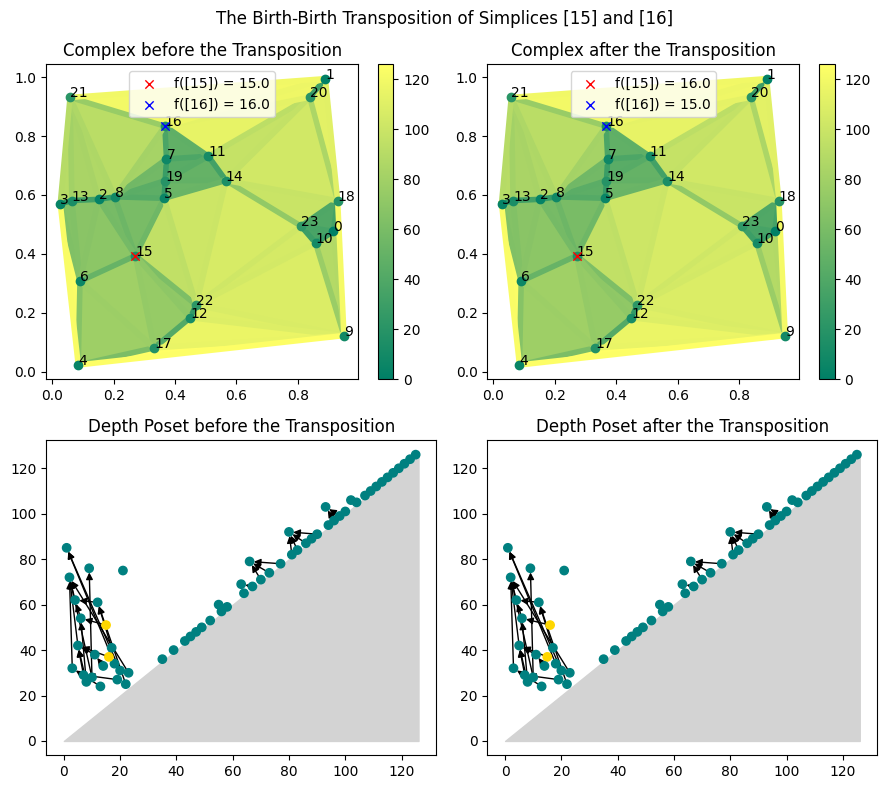

In [12]:
transposition = df_transpositions.loc[np.random.choice(df_transpositions.index)]

stree0, stree1 = get_strees(transposition, stree)

dp0 = DepthPoset.from_simplex_tree(stree0)
dp1 = DepthPoset.from_simplex_tree(stree1)

fig, axs = plot_transposition(transposition, stree0, stree1, dp0, dp1)
plt.tight_layout()
plt.show()

## Classifying the Transpositions

In [13]:
def get_xyab_bb(transposition, dp0: DepthPoset):
    # Returns x, y, a, b indices for birth-birth case
    if transposition['type'] != 'birth-birth':
        return None
    for node in dp0.nodes:
        if node.birth_index == transposition['index 0']:
            x = node.birth_index
            y = node.death_index
        if node.birth_index == transposition['index 1']:
            a = node.birth_index
            b = node.death_index
    return x, y, a, b

def get_xyab_dd(transposition, dp0: DepthPoset):
    # Returns x, y, a, b indices for death-death case
    if transposition['type'] != 'death-death':
        return None
    for node in dp0.nodes:
        if node.death_index == transposition['index 0']:
            x = node.birth_index
            y = node.death_index
        if node.death_index == transposition['index 1']:
            a = node.birth_index
            b = node.death_index
    return x, y, a, b

def get_xyab_bd(transposition, dp0: DepthPoset):
    # Returns x, y, a, b indices for birth-death case
    if transposition['type'] != 'birth-death':
        return None
    for node in dp0.nodes:
        if node.death_index == transposition['index 0']:
            a = node.birth_index
            b = node.death_index
        if node.death_index == transposition['index 1']:
            a = node.birth_index
            b = node.death_index
        if node.birth_index == transposition['index 0']:
            x = node.birth_index
            y = node.death_index
        if node.birth_index == transposition['index 1']:
            x = node.birth_index
            y = node.death_index
    return x, y, a, b
    
def get_xyab(transposition, dp0: DepthPoset):
    # 
    try:
        if transposition['type'] == 'birth-birth':
            return get_xyab_bb(transposition, dp0)
        if transposition['type'] == 'death-death':
            return get_xyab_dd(transposition, dp0)
        if transposition['type'] == 'birth-death':
            return get_xyab_bd(transposition, dp0)
    except UnboundLocalError:
        return None

In [14]:
df_transpositions['xyab'] = [get_xyab(transposition, dp0) for i, transposition in df_transpositions.iterrows()]

assert df_transpositions['xyab'].isna().sum() == 1

print(f'df_transpositions.shape = {df_transpositions.shape}')
df_transpositions.head()

df_transpositions.shape = (92, 10)


,index 0,index 1,value 0,value 1,simplex 0,simplex 1,dim 0,dim 1,type,xyab
0,0,1,0.0,1.0,[0],[1],0,0,birth-birth,None
1,1,2,1.0,2.0,[1],[2],0,0,birth-birth,"(1, 85, 2, 72)"
2,2,3,2.0,3.0,[2],[3],0,0,birth-birth,"(2, 72, 3, 32)"
3,3,4,3.0,4.0,[3],[4],0,0,birth-birth,"(3, 32, 4, 62)"
4,4,5,4.0,5.0,[4],[5],0,0,birth-birth,"(4, 62, 5, 42)"


In [15]:
def get_transposition_relations_and_classifying_matrix(stree0, dp0, transposition):
    # 
    order0, border_matrix0 = depth.get_ordered_border_matrix_from_simplex_tree(stree0)
    try:
        x, y, a, b = get_xyab(transposition, dp0)
    except TypeError:
        return None, None, None

    stop_condition = lambda alpha, b0, delta: len({(a, b), (a, y), (x, b), (x, y)} & set(alpha.values())) + \
                                              len({(a, x), (x, a), (b, y), (y, b)} & set(b0)) > 0
    if transposition['type'] == 'birth-birth':
        #stop_condition = lambda alpha, b0, delta0: len({(a, b), (a, y), (x, b), (x, y)} & set(alpha.values())) + len({(b, y), (y, b)} & set (b0)) != 0
        alpha, b0, delta0 = depth.reduct_column_bottom_to_top(border_matrix0, stop_condition)
        return list(alpha.values()), b0, tuple(map(tuple, delta0[np.sort([x, a])][:, np.sort([y, b])]))
    if transposition['type'] == 'death-death':
        #stop_condition = lambda omega, b1, delta1: len({(a, b), (a, y), (x, b), (x, y)} & set(omega.values())) + len({(a, x), (x, a)} & set (b1)) != 0
        omega, b1, delta1 = depth.reduct_row_left_to_right(border_matrix0, stop_condition)
        return list(omega.values()), b1, tuple(map(tuple, delta1[np.sort([x, a])][:, np.sort([y, b])]))
    if transposition['type'] == 'birth-death':
        #stop_condition = lambda alpha, b0, delta0: len({(a, b), (a, y), (x, b), (x, y)} & set(alpha.values())) + len({(b, y), (y, b)} & set (b0)) != 0
        alpha, b0, delta0 = depth.reduct_column_bottom_to_top(border_matrix0, stop_condition)
        #stop_condition = lambda omega, b1, delta1: len({(a, b), (a, y), (x, b), (x, y)} & set(omega.values())) + len({(a, x), (x, a)} & set (b1)) != 0
        omega, b1, delta1 = depth.reduct_row_left_to_right(delta0, stop_condition)
        return list(alpha.values()) + list(omega.values()), b0 + b1, tuple(map(tuple, delta1[np.sort([a, b, x, y])][:, np.sort([a, b, x, y])]))
        

In [16]:
(df_transpositions['bd-pairs'], 
 df_transpositions['relations'], 
 df_transpositions['classifying matrix']) = zip(*[get_transposition_relations_and_classifying_matrix(stree0, dp0, transposition) for i, transposition in df_transpositions.iterrows()])


assert df_transpositions['relations'].isna().sum() == 1
assert df_transpositions['classifying matrix'].isna().sum() == 1

print(f'df_transpositions.shape = {df_transpositions.shape}')
df_transpositions.head()

df_transpositions.shape = (92, 13)


,index 0,index 1,value 0,value 1,simplex 0,simplex 1,dim 0,dim 1,type,xyab,bd-pairs,relations,classifying matrix
0,0,1,0.0,1.0,[0],[1],0,0,birth-birth,None,None,None,None
1,1,2,1.0,2.0,[1],[2],0,0,birth-birth,"(1, 85, 2, 72)","[(125, 126), (123, 124), (121, 122), (119, 120...","[(99, 103), (97, 103), (87, 92), (84, 92), (82...","((0, 1), (1, 0))"
2,2,3,2.0,3.0,[2],[3],0,0,birth-birth,"(2, 72, 3, 32)","[(125, 126), (123, 124), (121, 122), (119, 120...","[(99, 103), (97, 103), (87, 92), (84, 92), (82...","((1, 1), (1, 0))"
3,3,4,3.0,4.0,[3],[4],0,0,birth-birth,"(3, 32, 4, 62)","[(125, 126), (123, 124), (121, 122), (119, 120...","[(99, 103), (97, 103), (87, 92), (84, 92), (82...","((1, 0), (0, 1))"
4,4,5,4.0,5.0,[4],[5],0,0,birth-birth,"(4, 62, 5, 42)","[(125, 126), (123, 124), (121, 122), (119, 120...","[(99, 103), (97, 103), (87, 92), (84, 92), (82...","((0, 1), (1, 0))"


In [17]:
def get_switch_type(stree0, dp0, transposition):
    # 
    alpha, omega, matrix = get_transposition_relations_and_classifying_matrix(stree0, dp0, transposition)

    if transposition['type'] == 'birth-birth':
        if matrix == ((1, 1), 
                      (1, 0)):
            return "switch forward"
        if matrix == ((1, 0), 
                      (1, 1)):
            return "switch backward"
    if transposition['type'] == 'death-death':
        if matrix == ((0, 1), 
                      (1, 1)):
            return "switch forward"
        if matrix == ((1, 0), 
                      (1, 1)):
            return "switch backward"
    if transposition['type'] == 'birth-death':
        if matrix == ((0, 1, 1, 0), 
                      (0, 0, 0, 1), 
                      (0, 0, 0, 1), 
                      (0, 0, 0, 0)):
            return "switch forward"
    return 'no switch'

In [18]:
df_transpositions['switch'] = df_transpositions.apply(lambda row: get_switch_type(stree0, dp0, row), axis=1)

df_transpositions['switch'].value_counts()

switch
no switch          86
switch backward     4
switch forward      2
Name: count, dtype: int64

In [19]:
expected_classifying_matrices = {
    'birth-birth': [((1, 1), 
                     (1, 0)), 
                    ((1, 0), 
                     (1, 1)), 
                    ((0, 1), 
                     (1, 1)), 
                    ((1, 1), 
                     (0, 1)), 
                    ((0, 1), 
                     (1, 0)), 
                    ((1, 0), 
                     (0, 1)),
                    None, 
                   ], 
    'death-death': [((0, 1), 
                     (1, 1)), 
                    ((1, 0), 
                     (1, 1)), 
                    ((1, 1), 
                     (1, 0)), 
                    ((1, 1), 
                     (0, 1)), 
                    ((0, 1), 
                     (1, 0)), 
                    ((1, 0), 
                     (0, 1)), 
                   ],
    'birth-death': [((0, 1, 1, 0), 
                     (0, 0, 0, 1), 
                     (0, 0, 0, 1), 
                     (0, 0, 0, 0)), 
                    ((0, 1, 0, 0), 
                     (0, 0, 0, 0), 
                     (0, 0, 0, 1), 
                     (0, 0, 0, 0)), 
                    ((0, 0, 1, 0), 
                     (0, 0, 0, 1), 
                     (0, 0, 0, 0), 
                     (0, 0, 0, 0)), 
                   ]
}

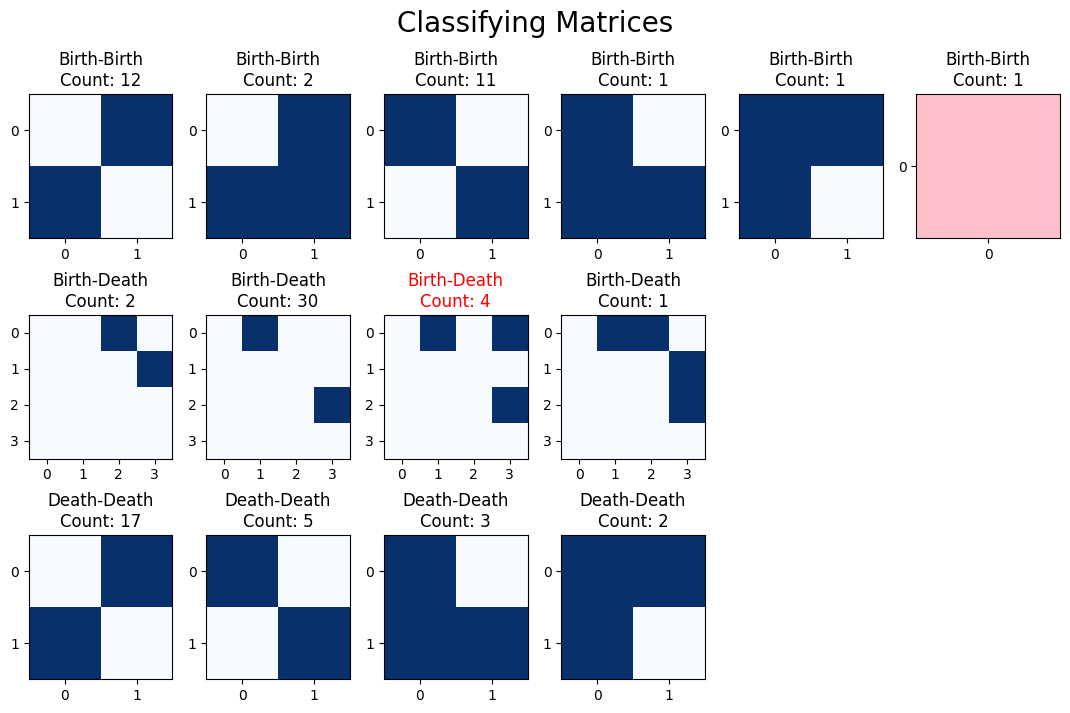

In [20]:
situations = df_transpositions[['type', 'classifying matrix', 'xyab']].fillna('None').rename(columns={'xyab': 'count'})
situations = situations.groupby(['type', 'classifying matrix'], as_index=False).count().replace('None', None)

situations['expected'] = situations.apply(lambda row: row['classifying matrix'] in expected_classifying_matrices[row['type']], axis=1)


n = situations['type'].value_counts().max()
m = len(pd.unique(situations['type']))
fig, axs = plt.subplots(m, n, figsize=(1.8*n, 2.4*m))
fig.suptitle('Classifying Matrices', fontsize=20)

cmap = plt.get_cmap('Blues')
cmap.set_bad(color='pink')

for j, situation_type in enumerate(pd.unique(situations['type'])):
    these_situations = situations[situations['type'] == situation_type].reset_index(drop=True)
    for i, situation in these_situations.iterrows():
        matrix = these_situations.loc[i, 'classifying matrix']
        if matrix is None:
            matrix = np.nan*np.ones([1, 1])
        matrix = np.array(matrix)
        axs[j, i].set_title(f'{situation_type.replace('b', 'B').replace('d', 'D')}\nCount: {situation['count']}', 
                            color='black' if situation['expected'] else 'red')
        axs[j, i].imshow(matrix, cmap=cmap, vmin=0, vmax=1, origin='upper')
        axs[j, i].set_xticks(np.arange(matrix.shape[1]))
        axs[j, i].set_yticks(np.arange(matrix.shape[0]))
    for i in range(len(these_situations), n):
        axs[j, i].set_xticks([])
        axs[j, i].set_yticks([])
        for spine in axs[j, i].spines.values():
            spine.set_visible(False)

plt.tight_layout()
plt.show()

In [21]:
df_transpositions['expected'] = df_transpositions.apply(lambda row: row['classifying matrix'] in expected_classifying_matrices[row['type']], axis=1)

print(f"There are {(~df_transpositions['expected']).sum()} unexpected situations.")


There are 4 unexpected situations.


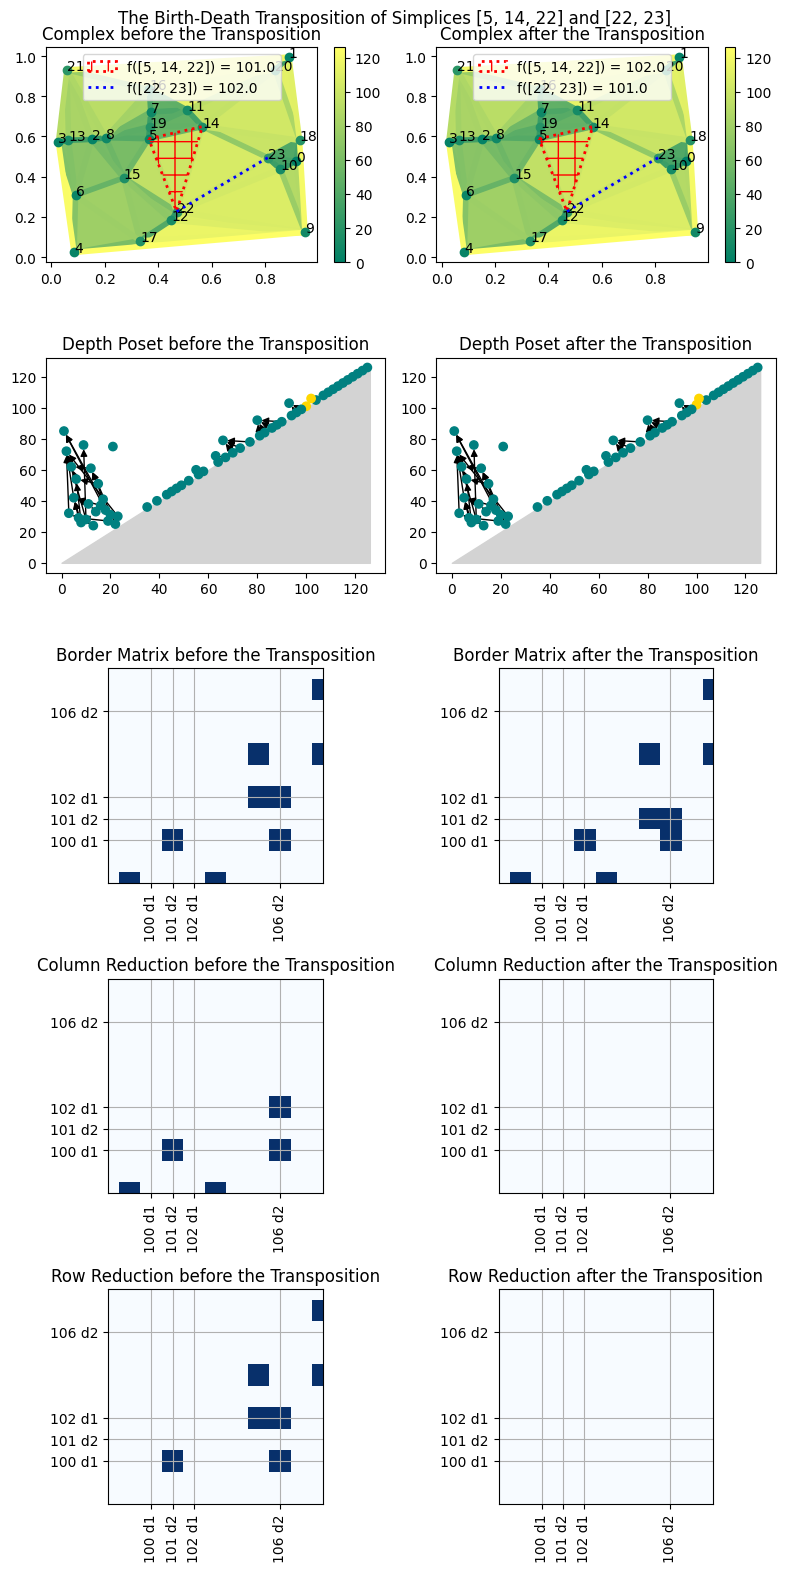

In [22]:
drow_more = True

for i, transposition in df_transpositions[~df_transpositions['expected']].iterrows():
    stree0, stree1 = get_strees(transposition, stree)

    dp0 = DepthPoset.from_simplex_tree(stree0)
    dp1 = DepthPoset.from_simplex_tree(stree1)

    fig, axs = plt.subplots(5, 2, figsize=(8, 16))
    fig, axs = plot_transposition(transposition, stree0, stree1, dp0, dp1, fig=fig, axs=axs)

    x, y, a, b = get_xyab(transposition, dp0)
    assert (np.sort([x, y, a, b]) == np.sort(get_xyab(transposition, dp1))).all()
    
    lim_min = np.min([x, y, a, b]) - 2
    lim_max = np.max([x, y, a, b]) + 3
    extents = [(lim_min, lim_min), 
               (lim_min, lim_max), 
               (lim_max, lim_min), 
               (lim_max, lim_max), 
              ]

    order0, border_matrix0 = depth.get_ordered_border_matrix_from_simplex_tree(stree0)
    order1, border_matrix1 = depth.get_ordered_border_matrix_from_simplex_tree(stree1)

    axs[2, 0].set_title('Border Matrix before the Transposition')
    axs[2, 1].set_title('Border Matrix after the Transposition')
    axs[2, 0].imshow(border_matrix0, cmap='Blues', origin='upper')
    axs[2, 1].imshow(border_matrix1, cmap='Blues', origin='upper')
    
    stop_condition = lambda alpha, b0, delta: len({(a, b), (a, y), (x, b), (x, y)} & set(alpha.values())) + \
                                              len({(a, x), (x, a), (b, y), (y, b)} & set(b0)) > 0
    alpha0, b00, delta00 = depth.reduct_column_bottom_to_top(border_matrix0, stop_condition)
    alpha1, b01, delta01 = depth.reduct_column_bottom_to_top(border_matrix1, stop_condition)

    axs[3, 0].set_title('Column Reduction before the Transposition')
    axs[3, 1].set_title('Column Reduction after the Transposition')
    axs[3, 0].imshow(delta00, cmap='Blues', origin='upper')
    axs[3, 1].imshow(delta01, cmap='Blues', origin='upper')
    
    omega0, b10, delta10 = depth.reduct_row_left_to_right(border_matrix0, stop_condition)
    omega1, b11, delta11 = depth.reduct_row_left_to_right(border_matrix1, stop_condition)

    axs[4, 0].set_title('Row Reduction before the Transposition')
    axs[4, 1].set_title('Row Reduction after the Transposition')
    axs[4, 0].imshow(delta10, cmap='Blues', origin='upper')
    axs[4, 1].imshow(delta11, cmap='Blues', origin='upper')

    ticks = np.sort([x, y, a, b])
    for j2 in [2, 3, 4]:
        axs[j2, 0].set_xticks(ticks, labels=[f'{tick} d{len(order0[tick]) - 1}' for tick in ticks], rotation=90)
        axs[j2, 0].set_yticks(ticks, labels=[f'{tick} d{len(order0[tick]) - 1}' for tick in ticks], rotation=0)
        axs[j2, 1].set_xticks(ticks, labels=[f'{tick} d{len(order0[tick]) - 1}' for tick in ticks], rotation=90)
        axs[j2, 1].set_yticks(ticks, labels=[f'{tick} d{len(order0[tick]) - 1}' for tick in ticks], rotation=0)
        for j in range(2):
            axs[j2, j].set_xlim(lim_min, lim_max - 1)
            axs[j2, j].set_ylim(lim_min, lim_max - 1)
            axs[j2, j].grid(True)

    plt.tight_layout()
    plt.savefig(f'pics/unexpected_transposition-{i}.png')

    # Show an example only once
    if drow_more:
        plt.show()
        drow_more = False
    else:
        plt.close()

In [23]:
df_transpositions.groupby(['type', 'switch']).count()

index 0  index 1  value 0  value 1  simplex 0  \
type        switch                                                           
birth-birth no switch             26       26       26       26         26   
            switch backward        1        1        1        1          1   
            switch forward         1        1        1        1          1   
birth-death no switch             36       36       36       36         36   
            switch forward         1        1        1        1          1   
death-death no switch             24       24       24       24         24   
            switch backward        3        3        3        3          3   

                             simplex 1  dim 0  dim 1  xyab  bd-pairs  \
type        switch                                                     
birth-birth no switch               26     26     26    25        25   
            switch backward          1      1      1     1         1   
            switch forward           1      1      1     1         1   
birth-death no switch               36     36     36    36        36   
            switch forward           1      1      1     1         1   
death-death no switch               24     24     24    24        24   
            switch backward          3      3      3     3         3   

                             relations  classifying matrix  expected  
type        switch                                                    
birth-birth no switch               25                  25        26  
            switch backward          1                   1         1  
            switch forward           1                   1         1  
birth-death no switch               36                  36        36  
            switch forward           1                   1         1  
death-death no switch               24                  24        24  
            switch backward          3                   3         3

# Basic Set Difference Measures

In [24]:
def jacard_index(a, b):
    """
    Calculate the Jaccard index
    """
    intersection = set(a) & set(b)
    union = set(a) | set(b)
    if len(union) == 0:
        return 1
    return len(intersection) / len(union)

# Lemmas and Hypothesises

Write $\text{Succ}(s, t) = \text{Succ}'(s, t) = \text{Succ}''(s, t)$ for the succesors and $\text{Pred}(s, t) = \text{Pred}'(s, t) = \text{Pred}''(s, t)$ for the predecessors (ancessors) of the pair in $D$, $D'$, $D''$, respectively.

Since $D = D' \cup D''$, we also have $\text{Succ}(s, t) = \text{Succ}'(s, t) \cup \text{Succ}''(s, t)$ and $\text{Pred}(s, t) = \text{Pred}'(s, t) \cup \text{Pred}''(s, t)$.

## Lemma 3.1.
Suppose $(x, y)$ and $(a, b)$ are birth-death pairs of $f: X\to R$, $a, x$ are consecutive in the ordering of the cellls by $f$, and the transposition $a, x$ is a switch. Then
$$
\text{Succ}'(a, y) = \{(x, b)\} \cup \text{Succ}'(a, b) \cup \{(s, t)\in \text{Succ}'(x, y) | f(t)<f(b)\}
$$
$$
\text{Succ}'(x, b) = \{(s, t)\in \text{Succ}'(x, y) | f(t) > f(b)\}
$$


In [25]:
transposition = df_transpositions.loc[np.random.choice(df_transpositions[(df_transpositions['type'] == 'birth-birth') &
                                                                         (df_transpositions['switch'] != 'no switch')].index)]

stree0, stree1 = get_strees(transposition, stree)

if transposition['switch'] == 'switch backward':
    print("'switch backward' will be reformated to 'switch forward'")
    transposition = pd.Series(get_transposition(stree1, transposition['index 0'], transposition['index 1']))
    stree0, stree1 = get_strees(transposition, stree1)

dp0 = DepthPoset.from_simplex_tree(stree0)
dp1 = DepthPoset.from_simplex_tree(stree1)

try:
    assert transposition['switch'] == get_switch_type(stree0, dp0, transposition)
except KeyError:
    transposition['switch'] = get_switch_type(stree0, dp0, transposition)
    forward_bd_pairs, forward_relations, forward_classifying_matrix = get_transposition_relations_and_classifying_matrix(stree0, dp0, transposition)
    transposition['bd-pairs'] = forward_bd_pairs
    transposition['classifying matrix'] = forward_classifying_matrix
    transposition['relations'] = forward_relations    
    transposition['xyab'] = get_xyab(transposition, dp0)

    
transposition_backward = pd.Series(get_transposition(stree1, transposition['index 0'], transposition['index 1']))
transposition_backward['switch'] = get_switch_type(stree1, dp1, transposition_backward)

backward_bd_pairs, backward_relations, backward_classifying_matrix = get_transposition_relations_and_classifying_matrix(stree1, dp1, transposition_backward)
transposition_backward['bd-pairs'] = backward_bd_pairs
transposition_backward['classifying matrix'] = backward_classifying_matrix
transposition_backward['relations'] = backward_relations

transposition_backward['xyab'] = get_xyab(transposition_backward, dp1)


pd.DataFrame({'forward': transposition, 
              'backward': transposition_backward})

'switch backward' will be reformated to 'switch forward'


,forward,backward
index 0,63,63
index 1,64,64
value 0,63.0,63.0
value 1,64.0,64.0
simplex 0,"[6, 13]","[3, 6]"
simplex 1,"[3, 6]","[6, 13]"
dim 0,1,1
dim 1,1,1
type,birth-birth,birth-birth
switch,switch forward,switch backward


Let's denote the sets from Lemma:
1. $\text{Succ}'(a, y)$ - __l31_set0__
2. $\{(x, b)\}$ - __l31_set1__
3. $\text{Succ}'(a, b)$ - __l31_set2__
4. $\{(s, t)\in \text{Succ}'(x, y) | f(t)<f(b)\}$ - __l31_set3__
5. $\text{Succ}'(x, b)$ - __l31_set4__
6. $\{(s, t)\in \text{Succ}'(x, y) | f(t) > f(b)\}$ - __l31_set5__

Now the Lemma 3.1 will be look like
$$
    \textbf{l31\_set0} = \textbf{l31\_set1} \cup \textbf{l31\_set2} \cup \textbf{l31\_set3} 
$$
$$
    \textbf{l31\_set4} = \textbf{l31\_set5}
$$

In [26]:
def l31_set0(stree0, stree1, dp0, dp1, transposition):
    r"""
    $
    \text{Succ}'(a, y)
    $
    """
    order0, border_matrix0 = depth.get_ordered_border_matrix_from_simplex_tree(stree0)
    
    x, y, a, b = get_xyab(transposition, dp0)
    sx, sy, sa, sb = np.array(order0, dtype=object)[[x, y, a, b]]

    order1, border_matrix1 = depth.get_ordered_border_matrix_from_simplex_tree(stree1)
    stop_condition = lambda alpha, b0, delta: (sa, sy) in [(order1[i], order1[j]) for i, j in alpha.values()]
    
    alpha, b0, delta0 = depth.reduct_column_bottom_to_top(border_matrix1, stop_condition)
    
    return [(order1[i], order1[j]) for i, j in alpha.values()]

def l31_set1(stree0, stree1, dp0, dp1, transposition):
    r"""
    $
    \{(x, b)\}
    $
    """
    order0, border_matrix0 = depth.get_ordered_border_matrix_from_simplex_tree(stree0)
    
    x, y, a, b = get_xyab(transposition, dp0)
    sx, sy, sa, sb = np.array(order0, dtype=object)[[x, y, a, b]]

    return [(sx, sb)]

def l31_set2(stree0, stree1, dp0, dp1, transposition):
    r"""
    $
    \text{Succ}'(a, b)
    $
    """
    order0, border_matrix0 = depth.get_ordered_border_matrix_from_simplex_tree(stree0)
    
    x, y, a, b = get_xyab(transposition, dp0)
    sx, sy, sa, sb = np.array(order0, dtype=object)[[x, y, a, b]]
    
    stop_condition = lambda alpha, b0, delta: (sa, sb) in [(order0[i], order0[j]) for i, j in alpha.values()]
    alpha, b0, delta0 = depth.reduct_column_bottom_to_top(border_matrix0, stop_condition)
    
    return [(order0[i], order0[j]) for i, j in alpha.values()]

def l31_set3(stree0, stree1, dp0, dp1, transposition):
    r"""
    $
    \{(s, t)\in \text{Succ}'(x, y) | f(t)<f(b)\}
    $
    """
    order0, border_matrix0 = depth.get_ordered_border_matrix_from_simplex_tree(stree0)
    
    x, y, a, b = get_xyab(transposition, dp0)
    sx, sy, sa, sb = np.array(order0, dtype=object)[[x, y, a, b]]
    
    stop_condition = lambda alpha, b0, delta: (sx, sy) in [(order0[i], order0[j]) for i, j in alpha.values()]
    alpha, b0, delta0 = depth.reduct_column_bottom_to_top(border_matrix0, stop_condition)

    res = [(s, t) for s, t in alpha.values() if t < b]
    
    return [(order0[i], order0[j]) for i, j in res]

In [27]:
def jacard_l31a(stree0, stree1, dp0, dp1, transposition):
    r"""
    Jacard Index of $\text{Succ}'(a, y)$ and $(\{(x, b)\} \cup \text{Succ}'(a, b) \cup \{(s, t)\in \text{Succ}'(x, y) | f(t)<f(b)\})$
    """
    set0 = l31_set0(stree0, stree1, dp0, dp1, transposition)
    set1 = []
    set1 += l31_set1(stree0, stree1, dp0, dp1, transposition)
    set1 += l31_set2(stree0, stree1, dp0, dp1, transposition)
    set1 += l31_set3(stree0, stree1, dp0, dp1, transposition)
    return jacard_index(set0, set1)

In [28]:
jacard_l31a(stree0, stree1, dp0, dp1, transposition)

0.9354838709677419

In [29]:
set0 = l31_set0(stree0, stree1, dp0, dp1, transposition)
set1 = []
set1 += l31_set1(stree0, stree1, dp0, dp1, transposition)
set1 += l31_set2(stree0, stree1, dp0, dp1, transposition)
set1 += l31_set3(stree0, stree1, dp0, dp1, transposition)

set0 = set(set0)
set1 = set(set1)

In [30]:
set0 - set1

{((3, 6), (2, 6, 15))}

In [31]:
set1 - set0

{((3, 6), (3, 6, 13))}

In [32]:
def l31_set4(stree0, stree1, dp0, dp1, transposition):
    r"""
    $
    \text{Succ}'(x, b)
    $
    """
    order0, border_matrix0 = depth.get_ordered_border_matrix_from_simplex_tree(stree0)
    
    x, y, a, b = get_xyab(transposition, dp0)
    sx, sy, sa, sb = np.array(order0, dtype=object)[[x, y, a, b]]

    order1, border_matrix1 = depth.get_ordered_border_matrix_from_simplex_tree(stree1)
    stop_condition = lambda alpha, b0, delta: (sx, sb) in [(order1[i], order1[j]) for i, j in alpha.values()]
    
    alpha, b1, delta1 = depth.reduct_column_bottom_to_top(border_matrix1, stop_condition)
    
    return [(order1[i], order1[j]) for i, j in alpha.values()]

def l31_set5(stree0, stree1, dp0, dp1, transposition):
    r"""
    $
    \{(s, t)\in \text{Succ}'(x, y) | f(t) > f(b)\}
    $
    """
    order0, border_matrix0 = depth.get_ordered_border_matrix_from_simplex_tree(stree0)
    
    x, y, a, b = get_xyab(transposition, dp0)
    sx, sy, sa, sb = np.array(order0, dtype=object)[[x, y, a, b]]
    
    stop_condition = lambda alpha, b0, delta: (sx, sy) in [(order0[i], order0[j]) for i, j in alpha.values()]
    alpha, b0, delta0 = depth.reduct_column_bottom_to_top(border_matrix0, stop_condition)

    res = [(s, t) for s, t in alpha.values() if t > b]
    
    return [(order0[i], order0[j]) for i, j in res]

In [33]:
def jacard_l31b(stree0, stree1, dp0, dp1, transposition):
    r"""
    Jacard Index of $\text{Succ}'(x, b)$ and $\{(s, t)\in \text{Succ}'(x, y) | f(t) > f(b)\}$
    """
    set0 = l31_set4(stree0, stree1, dp0, dp1, transposition)
    set1 = l31_set5(stree0, stree1, dp0, dp1, transposition)
    return jacard_index(set0, set1)

In [34]:
jacard_l31b(stree0, stree1, dp0, dp1, transposition)

0.9333333333333333

In [35]:
set0 = set(l31_set4(stree0, stree1, dp0, dp1, transposition))
set1 = set(l31_set5(stree0, stree1, dp0, dp1, transposition))


In [36]:
set0 - set1

{((6, 13), (3, 6, 13))}

In [37]:
set1 - set0

{((6, 13), (2, 6, 15))}

## Lemma 3.2.
Suppose $(a, b)$ and $(x, y)$ are birth-death pairs of $f:X\to R$, $y, b$ are consecutive in the ordering by $f$, and transposition of $y, b$ is a switch. Then
$$
\text{Succ}''(x, b) = \{(a, y)\} \cup \text{Succ}''(a, b) \cup \{(s, t)\in \text{Succ}''(x, y) | f(a) < f(s) < f(x)\}
$$
$$
\text{Succ}''(a, y) = \{(s, t)\in\text{Succ}''(x, y) | f(s) < f(a)\}
$$


In [38]:
transposition = df_transpositions.loc[np.random.choice(df_transpositions[(df_transpositions['type'] == 'death-death') &
                                                                         (df_transpositions['switch'] != 'no switch')].index)]

stree0, stree1 = get_strees(transposition, stree)

if transposition['switch'] == 'switch backward':
    print("'switch backward' will be reformated to 'switch forward'")
    transposition = pd.Series(get_transposition(stree1, transposition['index 0'], transposition['index 1']))
    stree0, stree1 = get_strees(transposition, stree1)

dp0 = DepthPoset.from_simplex_tree(stree0)
dp1 = DepthPoset.from_simplex_tree(stree1)

try:
    assert transposition['switch'] == get_switch_type(stree0, dp0, transposition)
except KeyError:
    transposition['switch'] = get_switch_type(stree0, dp0, transposition)
    forward_bd_pairs, forward_relations, forward_classifying_matrix = get_transposition_relations_and_classifying_matrix(stree0, dp0, transposition)
    transposition['bd-pairs'] = forward_bd_pairs
    transposition['classifying matrix'] = forward_classifying_matrix
    transposition['relations'] = forward_relations    
    transposition['xyab'] = get_xyab(transposition, dp0)

    
transposition_backward = pd.Series(get_transposition(stree1, transposition['index 0'], transposition['index 1']))
transposition_backward['switch'] = get_switch_type(stree1, dp1, transposition_backward)

backward_bd_pairs, backward_relations, backward_classifying_matrix = get_transposition_relations_and_classifying_matrix(stree1, dp1, transposition_backward)
transposition_backward['bd-pairs'] = backward_bd_pairs
transposition_backward['classifying matrix'] = backward_classifying_matrix
transposition_backward['relations'] = backward_relations

transposition_backward['xyab'] = get_xyab(transposition_backward, dp1)


pd.DataFrame({'forward': transposition, 
              'backward': transposition_backward})

'switch backward' will be reformated to 'switch forward'


,forward,backward
index 0,68,68
index 1,69,69
value 0,68.0,68.0
value 1,69.0,69.0
simplex 0,"[2, 6, 15]","[2, 6, 13]"
simplex 1,"[2, 6, 13]","[2, 6, 15]"
dim 0,2,2
dim 1,2,2
type,death-death,death-death
switch,switch forward,switch backward


Let's denote these sets:
1. $\text{Succ}''(x, b)$ - __l32_set0__
2. $\{(a, y)\}$ - __l32_set1__
3. $\text{Succ}''(a, b)$ - __l32_set2__
4. $\{(s, t)\in \text{Succ}''(x, y) | f(a) < f(s) < f(x)\}$ - __l32_set3__
5. $\text{Succ}''(a, y)$ - __l32_set4__
6. $\{(s, t)\in \text{Succ}''(x, y) | f(s) < f(a)\}$ - __l32_set5__

Now the Lemma 3.2 will be look like
$$
    \textbf{l32\_set0} = \textbf{l32\_set1} \cup \textbf{l32\_set2} \cup \textbf{l32\_set3} 
$$
$$
    \textbf{l32\_set4} = \textbf{l32\_set5}
$$

In [39]:
def l32_set0(stree0, stree1, dp0, dp1, transposition):
    r"""
    $
    \text{Succ}''(x, b)
    $
    """
    order0, border_matrix0 = depth.get_ordered_border_matrix_from_simplex_tree(stree0)
    
    x, y, a, b = get_xyab(transposition, dp0)
    sx, sy, sa, sb = np.array(order0, dtype=object)[[x, y, a, b]]

    order1, border_matrix1 = depth.get_ordered_border_matrix_from_simplex_tree(stree1)
    stop_condition = lambda alpha, b0, delta: (sx, sb) in [(order1[i], order1[j]) for i, j in alpha.values()]
    
    alpha, b0, delta0 = depth.reduct_row_left_to_right(border_matrix1, stop_condition)
    
    return [(order1[i], order1[j]) for i, j in alpha.values()]

def l32_set1(stree0, stree1, dp0, dp1, transposition):
    r"""
    $
    \{(a, y)\}
    $
    """
    order0, border_matrix0 = depth.get_ordered_border_matrix_from_simplex_tree(stree0)
    
    x, y, a, b = get_xyab(transposition, dp0)
    sx, sy, sa, sb = np.array(order0, dtype=object)[[x, y, a, b]]

    return [(sa, sy)]

def l32_set2(stree0, stree1, dp0, dp1, transposition):
    r"""
    $
    \text{Succ}''(a, b)
    $
    """
    order0, border_matrix0 = depth.get_ordered_border_matrix_from_simplex_tree(stree0)
    
    x, y, a, b = get_xyab(transposition, dp0)
    sx, sy, sa, sb = np.array(order0, dtype=object)[[x, y, a, b]]
    
    stop_condition = lambda alpha, b0, delta: (sa, sb) in [(order0[i], order0[j]) for i, j in alpha.values()]
    alpha, b0, delta0 = depth.reduct_row_left_to_right(border_matrix0, stop_condition)
    
    return [(order0[i], order0[j]) for i, j in alpha.values()]

def l32_set3(stree0, stree1, dp0, dp1, transposition):
    r"""
    $
    \{(s, t)\in \text{Succ}''(x, y) | f(a) < f(s) < f(x)\}
    $
    """
    order0, border_matrix0 = depth.get_ordered_border_matrix_from_simplex_tree(stree0)
    
    x, y, a, b = get_xyab(transposition, dp0)
    sx, sy, sa, sb = np.array(order0, dtype=object)[[x, y, a, b]]
    
    stop_condition = lambda alpha, b0, delta: (sx, sy) in [(order0[i], order0[j]) for i, j in alpha.values()]
    alpha, b0, delta0 = depth.reduct_row_left_to_right(border_matrix0, stop_condition)

    res = [(s, t) for s, t in alpha.values() if (a < s) and (s < x)]
    
    return [(order0[i], order0[j]) for i, j in res]

In [40]:
def jacard_l32a(stree0, stree1, dp0, dp1, transposition):
    r"""
    Jacard Index of $\text{Succ}''(x, b)$ and $\{(a, y)\} \cup \text{Succ}''(a, b) \cup \{(s, t)\in \text{Succ}''(x, y) | f(a) < f(s) < f(x)\}$
    """
    set0 = l32_set0(stree0, stree1, dp0, dp1, transposition)
    set1 = []
    set1 += l32_set1(stree0, stree1, dp0, dp1, transposition)
    set1 += l32_set2(stree0, stree1, dp0, dp1, transposition)
    set1 += l32_set3(stree0, stree1, dp0, dp1, transposition)
    return jacard_index(set0, set1)

In [41]:
jacard_l32a(stree0, stree1, dp0, dp1, transposition)

0.8823529411764706

In [42]:
set0 = l32_set0(stree0, stree1, dp0, dp1, transposition)
set1 = []
set1 += l32_set1(stree0, stree1, dp0, dp1, transposition)
set1 += l32_set2(stree0, stree1, dp0, dp1, transposition)
set1 += l32_set3(stree0, stree1, dp0, dp1, transposition)

set0 = set(set0)
set1 = set(set1)

In [43]:
set0 - set1

{((2, 6), (2, 6, 13))}

In [44]:
set1 - set0

{((2, 6), (2, 6, 15)), ((3, 6), (2, 6, 13)), ((3, 6), (2, 6, 15))}

In [45]:
def l32_set4(stree0, stree1, dp0, dp1, transposition):
    r"""
    $
    \text{Succ}''(a, y)
    $
    """
    order0, border_matrix0 = depth.get_ordered_border_matrix_from_simplex_tree(stree0)
    
    x, y, a, b = get_xyab(transposition, dp0)
    sx, sy, sa, sb = np.array(order0, dtype=object)[[x, y, a, b]]

    order1, border_matrix1 = depth.get_ordered_border_matrix_from_simplex_tree(stree1)
    stop_condition = lambda alpha, b0, delta: (sa, sy) in [(order1[i], order1[j]) for i, j in alpha.values()]
    
    alpha, b1, delta1 = depth.reduct_row_left_to_right(border_matrix1, stop_condition)
    
    return [(order1[i], order1[j]) for i, j in alpha.values()]

def l32_set5(stree0, stree1, dp0, dp1, transposition):
    r"""
    $
    \{(s, t)\in \text{Succ}''(x, y) | f(s) < f(a)\}
    $
    """
    order0, border_matrix0 = depth.get_ordered_border_matrix_from_simplex_tree(stree0)
    
    x, y, a, b = get_xyab(transposition, dp0)
    sx, sy, sa, sb = np.array(order0, dtype=object)[[x, y, a, b]]
    
    stop_condition = lambda alpha, b0, delta: (sx, sy) in [(order0[i], order0[j]) for i, j in alpha.values()]
    alpha, b0, delta0 = depth.reduct_row_left_to_right(border_matrix0, stop_condition)

    res = [(s, t) for s, t in alpha.values() if s < a]
    
    return [(order0[i], order0[j]) for i, j in res]

In [46]:
def jacard_l32b(stree0, stree1, dp0, dp1, transposition):
    r"""
    Jacard Index of $\text{Succ}''(a, y)$ and $\{(s, t)\in \text{Succ}''(x, y) | f(s) < f(a)\}$
    """
    set0 = l32_set4(stree0, stree1, dp0, dp1, transposition)
    set1 = l32_set5(stree0, stree1, dp0, dp1, transposition)
    return jacard_index(set0, set1)

In [47]:
jacard_l32b(stree0, stree1, dp0, dp1, transposition)

0.90625

In [48]:
set0 = l32_set4(stree0, stree1, dp0, dp1, transposition)
set1 = l32_set5(stree0, stree1, dp0, dp1, transposition)

set0 = set(set0)
set1 = set(set1)

In [49]:
set0 - set1

{((2, 6), (2, 6, 13)), ((3, 6), (2, 6, 15)), ((6, 13), (3, 6, 13))}

In [50]:
set1 - set0

set()

## Lemma 3.3.
Suppose $(a, b)$ and $(x, y)$ are birth-death pairs of $f$: $X\to R$, $b, x$ are consecutive in the ordering by $f$, and the transposition of $b, x$ is a switch. Then
$$
\text{Succ}(a, x) = \text{Succ}(a, b)
\;\;\text{and}\;\; 
\text{Succ}(b, y) = \text{Succ}(x, y)
$$


In [51]:
transposition = df_transpositions.loc[np.random.choice(df_transpositions[(df_transpositions['type'] == 'birth-death') &
                                                                         (df_transpositions['switch'] != 'no switch')].index)]

stree0, stree1 = get_strees(transposition, stree)

if transposition['switch'] == 'switch backward':
    print("'switch backward' will be reformated to 'switch forward'")
    transposition = pd.Series(get_transposition(stree1, transposition['index 0'], transposition['index 1']))
    stree0, stree1 = get_strees(transposition, stree1)

dp0 = DepthPoset.from_simplex_tree(stree0)
dp1 = DepthPoset.from_simplex_tree(stree1)

try:
    assert transposition['switch'] == get_switch_type(stree0, dp0, transposition)
except KeyError:
    transposition['switch'] = get_switch_type(stree0, dp0, transposition)
    forward_bd_pairs, forward_relations, forward_classifying_matrix = get_transposition_relations_and_classifying_matrix(stree0, dp0, transposition)
    transposition['bd-pairs'] = forward_bd_pairs
    transposition['classifying matrix'] = forward_classifying_matrix
    transposition['relations'] = forward_relations    
    transposition['xyab'] = get_xyab(transposition, dp0)

    
transposition_backward = pd.Series(get_transposition(stree1, transposition['index 0'], transposition['index 1']))
transposition_backward['switch'] = get_switch_type(stree1, dp1, transposition_backward)

backward_bd_pairs, backward_relations, backward_classifying_matrix = get_transposition_relations_and_classifying_matrix(stree1, dp1, transposition_backward)
transposition_backward['bd-pairs'] = backward_bd_pairs
transposition_backward['classifying matrix'] = backward_classifying_matrix
transposition_backward['relations'] = backward_relations

transposition_backward['xyab'] = get_xyab(transposition_backward, dp1)


pd.DataFrame({'forward': transposition, 
              'backward': transposition_backward})

,forward,backward
bd-pairs,"[(125, 126), (123, 124), (121, 122), (119, 120...","[(125, 126), (123, 124), (121, 122), (119, 120..."
classifying matrix,"((0, 1, 1, 0), (0, 0, 0, 1), (0, 0, 0, 1), (0,...","((0, 1, 1, 0), (0, 0, 0, 1), (0, 0, 0, 1), (0,..."
dim 0,1,1
dim 1,1,1
expected,True,NaN
index 0,54,54
index 1,55,55
relations,"[(99, 103), (97, 103), (87, 92), (84, 92), (82...","[(99, 103), (97, 103), (87, 92), (84, 92), (82..."
simplex 0,"[8, 15]","[5, 15]"
simplex 1,"[5, 15]","[8, 15]"


Let's again rename the sets:
1. $\text{Succ}(a, x)$ - __l33_set0__ 
1. $\text{Succ}(a, b)$ - __l33_set1__ 
1. $\text{Succ}(b, y)$ - __l33_set2__ 
1. $\text{Succ}(x, y)$ - __l33_set3__ 

In [52]:
def l33_set0(stree0, stree1, dp0, dp1, transposition):
    r"""
    $
    \text{Succ}(a, x)
    $
    """
    order0, border_matrix0 = depth.get_ordered_border_matrix_from_simplex_tree(stree0)
    
    x, y, a, b = get_xyab(transposition, dp0)
    sx, sy, sa, sb = np.array(order0, dtype=object)[[x, y, a, b]]

    order1, border_matrix1 = depth.get_ordered_border_matrix_from_simplex_tree(stree1)
    stop_condition = lambda alpha, b0, delta: (sa, sx) in [(order1[i], order1[j]) for i, j in alpha.values()]
    
    alpha, b0, delta0 = depth.reduct_column_bottom_to_top(border_matrix1, stop_condition)
    omega, b1, delta1 = depth.reduct_row_left_to_right(delta0, stop_condition)
    
    return [(order1[i], order1[j]) for i, j in set(alpha.values()) | set(omega.values())]

def l33_set1(stree0, stree1, dp0, dp1, transposition):
    r"""
    $
    \text{Succ}(a, b)
    $
    """
    order0, border_matrix0 = depth.get_ordered_border_matrix_from_simplex_tree(stree0)
    
    x, y, a, b = get_xyab(transposition, dp0)
    sx, sy, sa, sb = np.array(order0, dtype=object)[[x, y, a, b]]

    order1, border_matrix1 = depth.get_ordered_border_matrix_from_simplex_tree(stree1)
    stop_condition = lambda alpha, b0, delta: (sa, sb) in [(order1[i], order1[j]) for i, j in alpha.values()]
    
    alpha, b0, delta0 = depth.reduct_column_bottom_to_top(border_matrix0, stop_condition)
    omega, b1, delta1 = depth.reduct_row_left_to_right(delta0, stop_condition)
    
    return [(order1[i], order1[j]) for i, j in set(alpha.values()) | set(omega.values())]

def jacard_l33a(stree0, stree1, dp0, dp1, transposition):
    """
    Jacard Index of $\text{Succ}(a, x)$ and $\text{Succ}(a, b)$
    """
    set0 = l33_set0(stree0, stree1, dp0, dp1, transposition)
    set1 = l33_set1(stree0, stree1, dp0, dp1, transposition)
    return jacard_index(set0, set1)

In [53]:
jacard_l33a(stree0, stree1, dp0, dp1, transposition)

0.9523809523809523

In [54]:
set0 = set(l33_set0(stree0, stree1, dp0, dp1, transposition))
set1 = set(l33_set1(stree0, stree1, dp0, dp1, transposition))

len(set0 - set1), len(set1 - set0), 

(0, 3)

In [55]:
def l33_set2(stree0, stree1, dp0, dp1, transposition):
    r"""
    $
    \text{Succ}(b, y)
    $
    """
    order0, border_matrix0 = depth.get_ordered_border_matrix_from_simplex_tree(stree0)
    
    x, y, a, b = get_xyab(transposition, dp0)
    sx, sy, sa, sb = np.array(order0, dtype=object)[[x, y, a, b]]

    order1, border_matrix1 = depth.get_ordered_border_matrix_from_simplex_tree(stree1)
    stop_condition = lambda alpha, b0, delta: (sb, sy) in [(order1[i], order1[j]) for i, j in alpha.values()]
    
    alpha, b0, delta0 = depth.reduct_column_bottom_to_top(border_matrix1, stop_condition)
    omega, b1, delta1 = depth.reduct_row_left_to_right(delta0, stop_condition)
    
    return [(order1[i], order1[j]) for i, j in set(alpha.values()) | set(omega.values())]

def l33_set3(stree0, stree1, dp0, dp1, transposition):
    r"""
    $
    \text{Succ}(x, y)
    $
    """
    order0, border_matrix0 = depth.get_ordered_border_matrix_from_simplex_tree(stree0)
    
    x, y, a, b = get_xyab(transposition, dp0)
    sx, sy, sa, sb = np.array(order0, dtype=object)[[x, y, a, b]]

    order1, border_matrix1 = depth.get_ordered_border_matrix_from_simplex_tree(stree1)
    stop_condition = lambda alpha, b0, delta: (sx, sy) in [(order1[i], order1[j]) for i, j in alpha.values()]
    
    alpha, b0, delta0 = depth.reduct_column_bottom_to_top(border_matrix0, stop_condition)
    omega, b1, delta1 = depth.reduct_row_left_to_right(delta0, stop_condition)
    
    return [(order1[i], order1[j]) for i, j in set(alpha.values()) | set(omega.values())]

def jacard_l33b(stree0, stree1, dp0, dp1, transposition):
    """
    Jacard Index of $\text{Succ}(b, y)$ and $\text{Succ}(x, y)$
    """
    set0 = l33_set0(stree0, stree1, dp0, dp1, transposition)
    set1 = l33_set1(stree0, stree1, dp0, dp1, transposition)
    return jacard_index(set0, set1)

In [56]:
jacard_l33b(stree0, stree1, dp0, dp1, transposition)

0.9523809523809523

In [57]:
set0 = set(l33_set2(stree0, stree1, dp0, dp1, transposition))
set1 = set(l33_set3(stree0, stree1, dp0, dp1, transposition))

len(set0 - set1), len(set1 - set0), 

(0, 6)

## General Scores

In [58]:
def jacard_nodes_filtration(dp0: DepthPoset, dp1: DepthPoset):
    """
    The Jacard index of node sets from 2 depth posets.
    The birth-death pairs are equal in terms of filtration values.
    """
    set0 = [(node.birth_value, node.death_value) for node in dp0.nodes]
    set1 = [(node.birth_value, node.death_value) for node in dp1.nodes]
    return jacard_index(set0, set1)

In [59]:
def jacard_nodes_simplex(dp0: DepthPoset, dp1: DepthPoset):
    """
    The Jacard index of nodes from 2 depth posets.
    The birth-death pairs are equal in terms of simplices.
    """
    set0 = [node.source for node in dp0.nodes]
    set1 = [node.source for node in dp1.nodes]
    return jacard_index(set0, set1)

In [60]:
def jacard_edges_filtration(dp0: DepthPoset, dp1: DepthPoset):
    """
    The Jacard index of edge sets from transitive reductions of 2 depth posets.
    The birth-death pairs are equal in terms of filtration values.
    """
    g0 = dp0.get_transitive_reduction()
    g1 = dp1.get_transitive_reduction()

    set0 = [((n0.birth_value, n0.death_value), (n1.birth_value, n1.death_value)) for n0, n1 in g0.edges]
    set1 = [((n0.birth_value, n0.death_value), (n1.birth_value, n1.death_value)) for n0, n1 in g1.edges]
    return jacard_index(set0, set1)

In [61]:
def jacard_edges_simplex(dp0: DepthPoset, dp1: DepthPoset):
    """
    The Jacard index of edge sets from transitive reductions of 2 depth posets.
    The birth-death pairs are equal in terms of simplices.
    """
    g0 = dp0.get_transitive_reduction()
    g1 = dp1.get_transitive_reduction()

    set0 = [(n0.source, n1.source) for n0, n1 in g0.edges]
    set1 = [(n0.source, n1.source) for n0, n1 in g1.edges]
    return jacard_index(set0, set1)

## Hypothesis 1: 
Suppose $a$ and $b$ are 2-simplices consecutive in the ordering by $f$. And there is another Morse function $f^*$: 
$$
f^*(s) = 
\begin{cases}
f(s), \; \text{if} \; s\ne a, b \\
f(b), \; \text{if} \; s = a \\
f(a), \; \text{if} \; s = b
\end{cases}
$$
Let's denote $DP_{f}$ the transitive reduction of the Depth Poset defined by the filtration $f$. And let's deonote $DP_{f}(s)$ the set of nodes in $DP_f(s)$ which are pairs containing cell $s$ and the set of edges with these nodes.

__Hypothesis:__ if the cell $s$ has no faces and cofaces with $a$ and $b$, then $DP_f(s) = DP_{f^*}(s)$.

# Scores

In [62]:
problems_scores = {'General': [jacard_nodes_filtration, 
                               jacard_nodes_simplex, 
                               jacard_edges_filtration, 
                               jacard_edges_simplex, 
                              ], 
                   'Lemma 3.1': [jacard_l31a, jacard_l31b], 
                   'Lemma 3.2': [jacard_l32a, jacard_l32b], 
                   'Lemma 3.3': [jacard_l33a, jacard_l33b], 
                  }

scores = np.concatenate(list(problems_scores.values()))

In [63]:
results = []

for i, transposition in tqdm(df_transpositions.iterrows(), total=len(df_transpositions)):
    # 
    stree0, stree1 = get_strees(transposition, stree)
    
    dp0 = DepthPoset.from_simplex_tree(stree0)
    dp1 = DepthPoset.from_simplex_tree(stree1)

    results_i = {}
    for score in scores:
        param_names = inspect.signature(score).parameters.keys()
        args = {name: value for name, value in locals().items() if name in param_names}
        try:
            value = score(**args)
        except Exception as err:
            value = err
        results_i.update({score.__name__: value})
    results.append(results_i)

results = pd.DataFrame(results)

df_transpositions = df_transpositions[np.setdiff1d(df_transpositions.columns, results.columns)]
df_transpositions = df_transpositions.join(results)

interesting_cols = np.concatenate([['value 0', 'value 1', 'simplex 0', 'simplex 1'], 
                                   ['type', 'switch'], 
                                   [score.__name__ for score in scores]])

print(f'df_transpositions.shape = {df_transpositions.shape}')
df_transpositions[interesting_cols].head()

100%|███████████████████████████████████████████| 92/92 [00:11<00:00,  7.94it/s]

df_transpositions.shape = (92, 25)


,value 0,value 1,simplex 0,simplex 1,type,switch,jacard_nodes_filtration,jacard_nodes_simplex,jacard_edges_filtration,jacard_edges_simplex,jacard_l31a,jacard_l31b,jacard_l32a,jacard_l32b,jacard_l33a,jacard_l33b
0,0.0,1.0,[0],[1],birth-birth,no switch,1.000000,0.968750,0.916667,0.815789,cannot unpack non-iterable NoneType object,cannot unpack non-iterable NoneType object,cannot unpack non-iterable NoneType object,cannot unpack non-iterable NoneType object,cannot unpack non-iterable NoneType object,cannot unpack non-iterable NoneType object
1,1.0,2.0,[1],[2],birth-birth,no switch,0.938462,1.000000,0.650000,1.000000,0.96875,0.460317,0.53125,0.015873,0.938462,0.938462
2,2.0,3.0,[2],[3],birth-birth,switch forward,1.000000,0.938462,0.970588,0.675000,0.968254,0.83871,0.727273,0.0,1.0,1.0
3,3.0,4.0,[3],[4],birth-birth,no switch,0.938462,1.000000,0.736842,1.000000,0.953125,0.507937,0.453125,0.015873,0.938462,0.938462
4,4.0,5.0,[4],[5],birth-birth,no switch,0.938462,1.000000,0.609756,1.000000,0.921875,0.698413,0.265625,0.031746,0.938462,0.938462


In [64]:
df_transpositions[df_transpositions['switch'] != 'no switch'][interesting_cols]

,value 0,value 1,simplex 0,simplex 1,type,switch,jacard_nodes_filtration,jacard_nodes_simplex,jacard_edges_filtration,jacard_edges_simplex,jacard_l31a,jacard_l31b,jacard_l32a,jacard_l32b,jacard_l33a,jacard_l33b
2,2.0,3.0,[2],[3],birth-birth,switch forward,1.0,0.938462,0.970588,0.675000,0.968254,0.83871,0.727273,0.0,1.0,1.0
47,54.0,55.0,"[8, 15]","[5, 15]",birth-death,switch forward,1.0,0.938462,0.885714,0.783784,0.848485,0.5,0.353846,0.031746,0.952381,0.952381
52,61.0,62.0,"[4, 17]","[15, 22]",death-death,switch backward,1.0,0.938462,0.970588,0.717949,0.951613,0.596154,0.870968,0.034483,1.0,1.0
54,63.0,64.0,"[3, 6]","[6, 13]",birth-birth,switch backward,1.0,0.938462,1.000000,0.885714,0.935484,0.933333,0.90625,0.878788,1.0,1.0
57,68.0,69.0,"[2, 6, 13]","[2, 6, 15]",death-death,switch backward,1.0,0.938462,1.000000,0.885714,0.90625,0.962963,0.882353,0.90625,1.0,1.0
64,78.0,79.0,"[4, 6, 17]","[6, 15, 17]",death-death,switch backward,1.0,0.938462,1.000000,0.833333,0.9,0.958333,0.902439,0.871795,1.0,1.0
